### Z-LPER - Developing a Performance Based Ranking for League of Legends Esports
ICCS261 Term Project, Artem Kiselev, 6580846

In [3]:
import os

import pandas as pd 

Combine all of Oracle's Elixir CSV files from 2014-2024 into one

In [4]:
folder_path = '../data/OraclesElixir'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

combined_df = pd.DataFrame()

for file in csv_files:
    for chunk in pd.read_csv(os.path.join(folder_path, file), chunksize=100000):
        combined_df = pd.concat([combined_df, chunk], ignore_index=True)

/var/folders/0h/ch124vqs7dj_96gjw7qq3ksh0000gn/T/ipykernel_83228/2872972160.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(os.path.join(folder_path, file), chunksize=100000):
/var/folders/0h/ch124vqs7dj_96gjw7qq3ksh0000gn/T/ipykernel_83228/2872972160.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(os.path.join(folder_path, file), chunksize=100000):
/var/folders/0h/ch124vqs7dj_96gjw7qq3ksh0000gn/T/ipykernel_83228/2872972160.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(os.path.join(folder_path, file), chunksize=100000):
/var/folders/0h/ch124vqs7dj_96gjw7qq3ksh0000gn/T/ipykernel_83228/2872972160.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(os.path.

Remove incomplete data and sort by date

In [5]:
combined_df = combined_df[combined_df['datacompleteness'] == 'complete']
combined_df = combined_df.sort_values(by='date').reset_index()

Remove any columns where at least 30% of them null

In [6]:
threshold = len(combined_df) * 0.7
columns_to_drop = [col for col in combined_df.columns if combined_df[col].isnull().sum() > threshold and col not in ['playername', 'playerid']]
df_c = combined_df.drop(columns=columns_to_drop)
df_c = df_c.dropna(thresh=threshold, axis=1)

Remove any minute-based metrics such as goldat15 goldat20 etc. since they are very similar to the full game metric and will introduce unnecessary complexity into the model

In [7]:
columns_with_at = [col for col in df_c.columns if 'at' in col]
columns_with_at.remove('date')
columns_with_at.remove('patch')
columns_with_at.remove('deaths')
columns_with_at.remove('teamdeaths')
columns_with_at.remove('damagemitigatedperminute')

df_cd = df_c.drop(columns=columns_with_at)

participantid 100 or 200 are team rows. Remove all team rows, leave only individual player rows

In [8]:
df_cdg = df_cd[~df_cd['participantid'].isin([100, 200])]

Remove unnecessary descriptive columns as well as multikill and firstblood statistics, due to the incredibly low significane these statistics have for a game

In [9]:
df_cdg = df_cdg.drop(columns=['year','date','patch','teamname','teamid','champion','ban1','ban2','ban3','ban4','ban5','doublekills','triplekills','quadrakills','pentakills','firstblood','firstbloodkill','firstbloodassist','firstbloodvictim', 'playerid'])

Select numeric (statistical) columns

In [10]:
numeric = df_cdg.select_dtypes(include=['float64', 'int64'])

Create correlation matrix of all numeric columns

In [11]:
corr_matrix = numeric.corr()
corr_matrix = corr_matrix.abs()

Heatmap of correlation

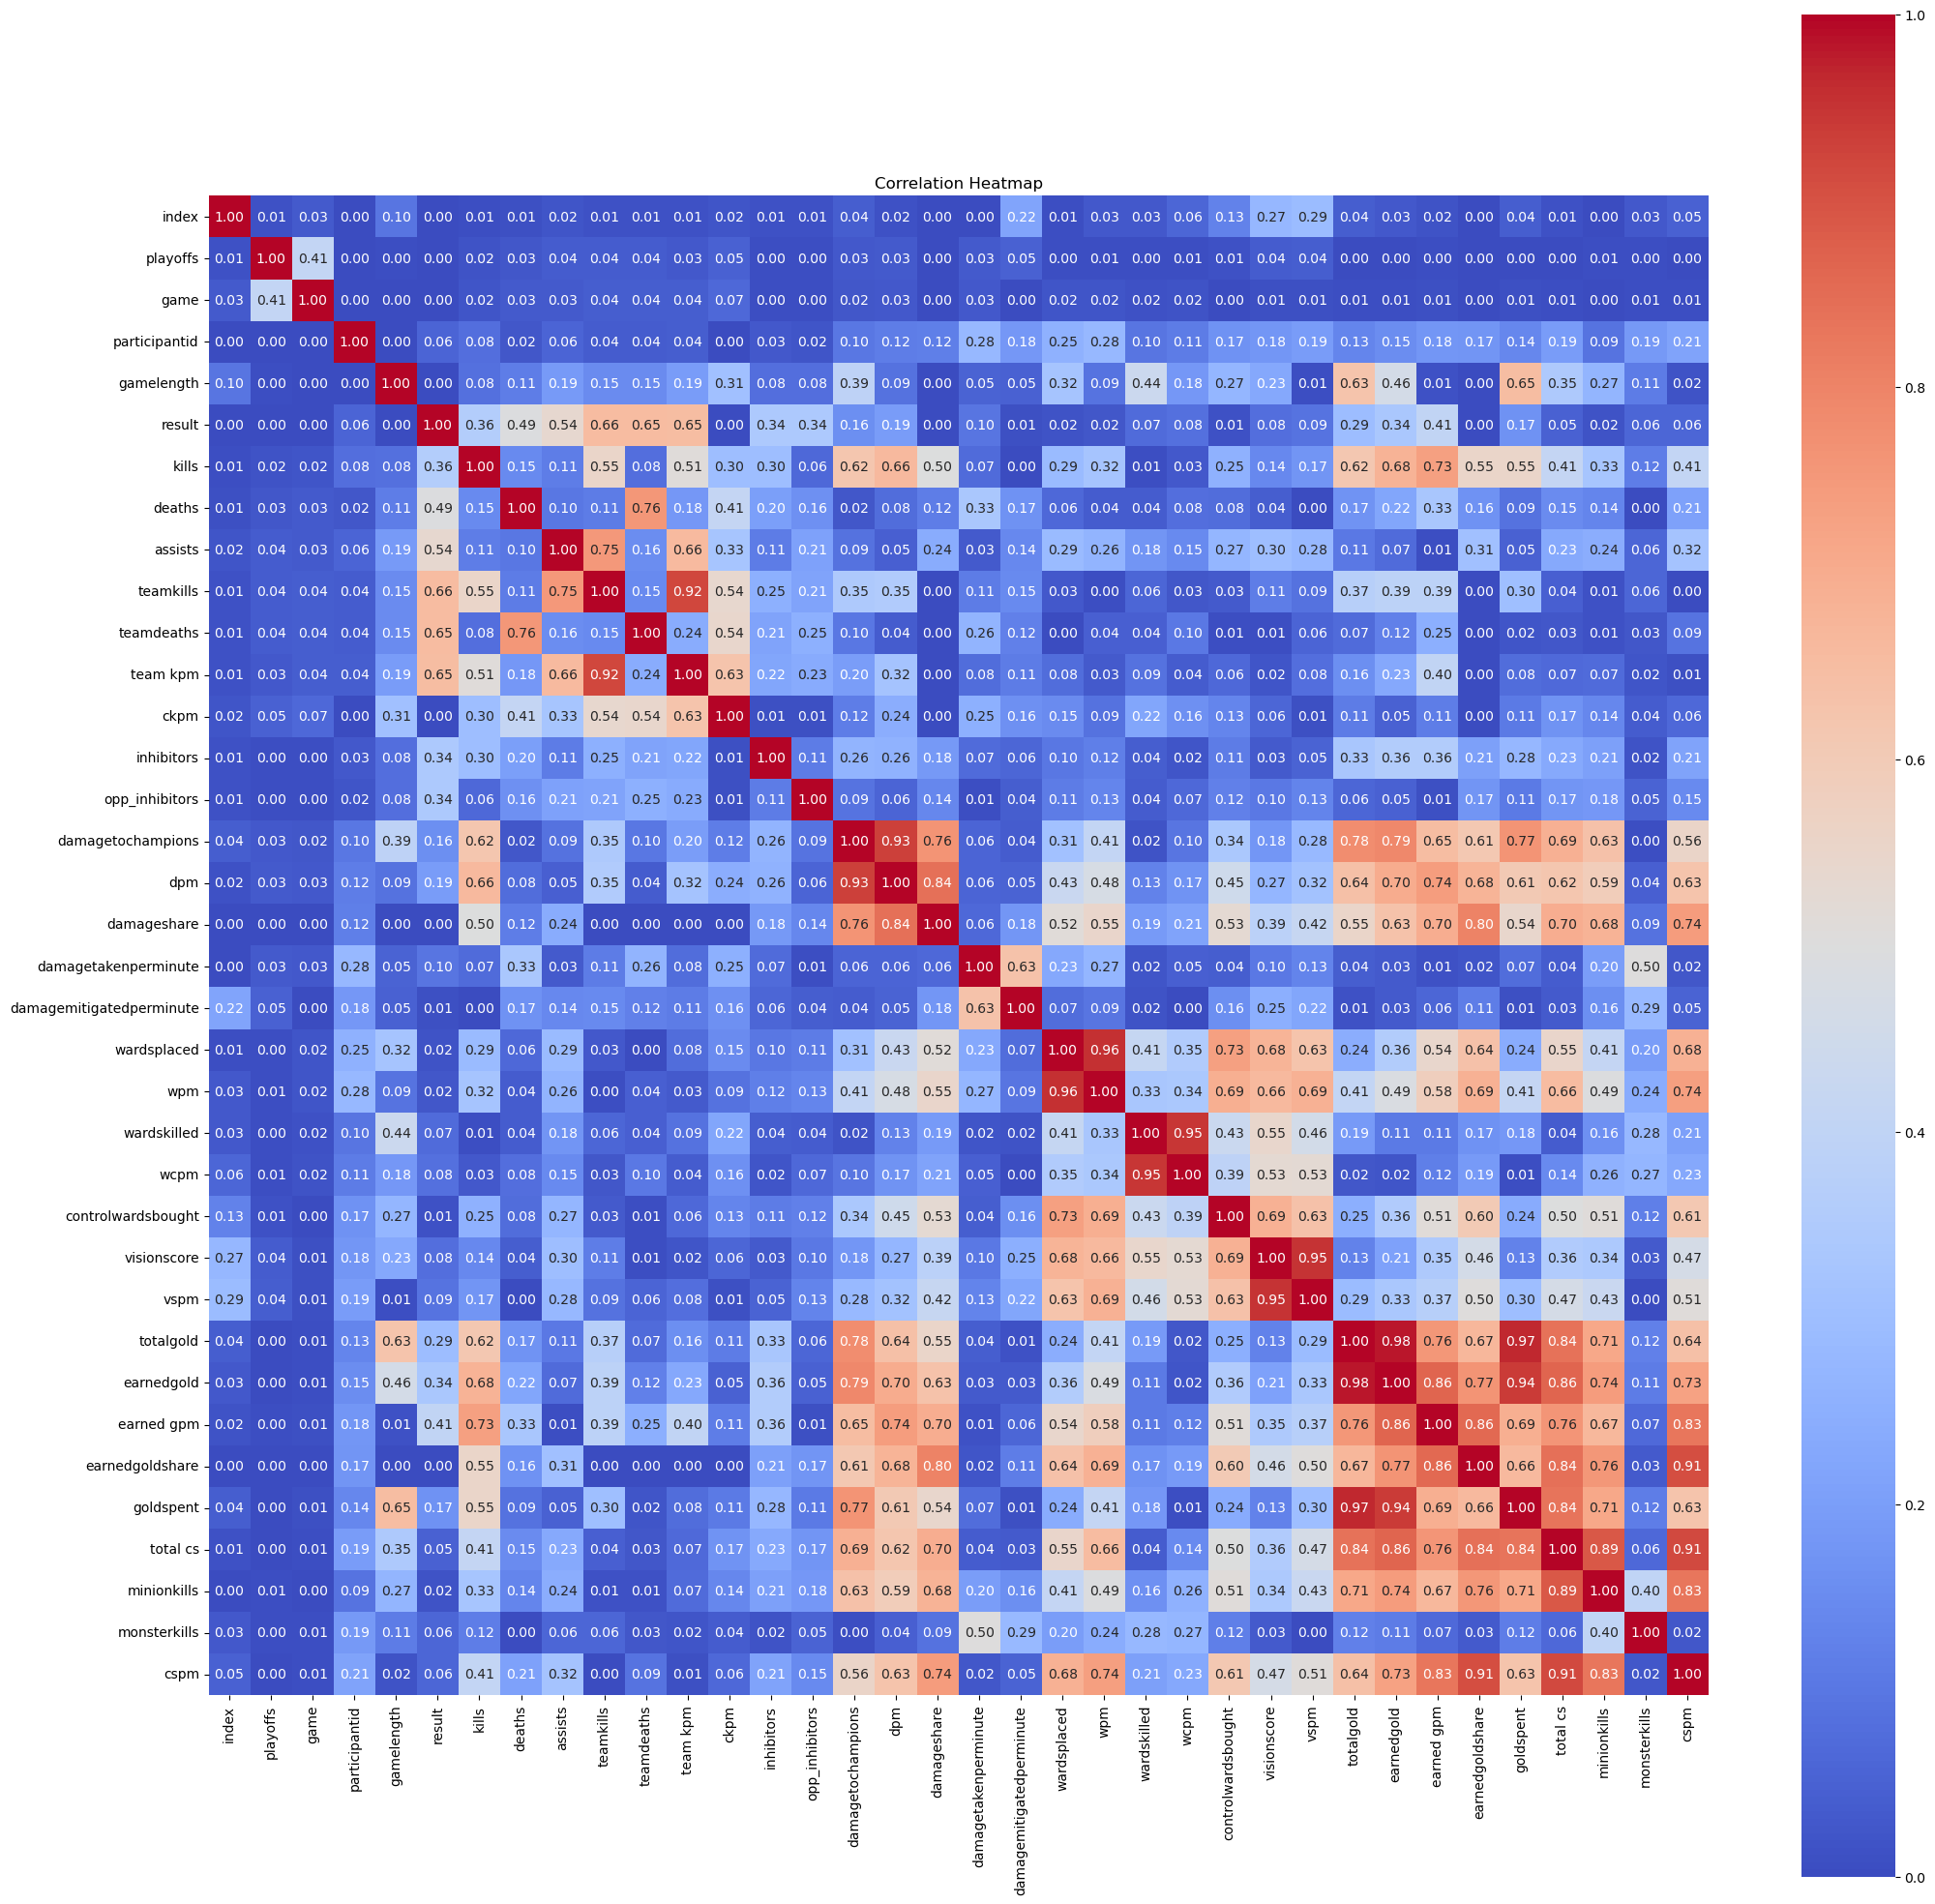

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Heatmap')
plt.show()

Find highly correlated columns

In [13]:
threshold = 0.8

high_corr_pairs = [
    (col1, col2)
    for col1 in corr_matrix.columns
    for col2 in corr_matrix.columns
    if col1 != col2 and corr_matrix.loc[col1, col2] > threshold
]

Drop one of each pair of highly correlated columns

In [14]:
to_drop = set()

for col1, col2 in high_corr_pairs:
    if col1 not in to_drop and col2 not in to_drop:
        to_drop.add(col2)  

print("Features to drop:")
print(to_drop)

df_reduced = df_cdg.drop(columns=to_drop)

Features to drop:
{'dpm', 'cspm', 'total cs', 'team kpm', 'goldspent', 'vspm', 'earnedgold', 'wcpm', 'earnedgoldshare', 'wpm'}


Examine data

In [15]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 726690 entries, 2 to 872027
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   index                     726690 non-null  int64  
 1   gameid                    726690 non-null  object 
 2   league                    726690 non-null  object 
 3   split                     556630 non-null  object 
 4   playoffs                  726690 non-null  int64  
 5   game                      726130 non-null  float64
 6   participantid             726690 non-null  int64  
 7   side                      726690 non-null  object 
 8   position                  726690 non-null  object 
 9   playername                726642 non-null  object 
 10  gamelength                726690 non-null  int64  
 11  result                    726690 non-null  int64  
 12  kills                     726690 non-null  int64  
 13  deaths                    726690 non-null  int64 

Still some missing data, clean

In [16]:
df_notna = df_reduced.dropna()

Dataset is now fully cleaned and is ready for the hypothesis test.

Finding out whether individual statisitcs of a professional League of Legends player contribute to the outcome of a game.

H0: There are no individual statisitcs for professional League of Legends players that significantly contribute towards the outcome of a game.

H1: There exist individual statistics for professional League of Legends players that significantly contribute towards the outcome of a game.

Filter by tier 1 leagues only for higher quality data

In [17]:
tier1 = ['LCS', 'LEC', 'LPL', 'LCK']
tier1_df = df_notna[df_notna['league'].isin(tier1)]

Remove any players with less than 50 tier 1 games played to further increase quality

In [18]:
player_counts = tier1_df['playername'].value_counts()
players_to_keep = player_counts[player_counts >= 50].index

tier1_df = tier1_df[tier1_df['playername'].isin(players_to_keep)]
df = tier1_df.reset_index(drop=True)

Separate the data into a features dataframe and the target variable

In [19]:
X = df.drop(columns=['gameid','split','league','playoffs','game','participantid','position','playername','gamelength','result', 'side', 'teamkills','teamdeaths','inhibitors','opp_inhibitors'])

y = df['result']

Inspect X

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68952 entries, 0 to 68951
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     68952 non-null  int64  
 1   kills                     68952 non-null  int64  
 2   deaths                    68952 non-null  int64  
 3   assists                   68952 non-null  int64  
 4   ckpm                      68952 non-null  float64
 5   damagetochampions         68952 non-null  float64
 6   damageshare               68952 non-null  float64
 7   damagetakenperminute      68952 non-null  float64
 8   damagemitigatedperminute  68952 non-null  float64
 9   wardsplaced               68952 non-null  float64
 10  wardskilled               68952 non-null  float64
 11  controlwardsbought        68952 non-null  float64
 12  visionscore               68952 non-null  float64
 13  totalgold                 68952 non-null  float64
 14  earned

Random index column we dont need

In [21]:
X = X.drop(columns=['index'])

Train Logistic Regression model on the features and the result of a game as the target

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm 

# train Logistic Regression model for p-values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = sm.add_constant(X_train)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

print("\nP-values from Logistic Regression:")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.203071
         Iterations 8

P-values from Logistic Regression:
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                48266
Model:                          Logit   Df Residuals:                    48249
Method:                           MLE   Df Model:                           16
Date:                Sun, 05 Jan 2025   Pseudo R-squ.:                  0.7070
Time:                        10:10:24   Log-Likelihood:                -9801.4
converged:                       True   LL-Null:                       -33447.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.2752      0.1

Analyze the accuracy of the model

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix

# add constant to the test set (for intercept)
X_test = sm.add_constant(X_test)
y_pred = result.predict(X_test)

# convert probabilities to binary predictions
y_pred_binary = (y_pred >= 0.5).astype(int)  

accuracy = accuracy_score(y_test, y_pred_binary)
error_rate = 1 - accuracy

print("\nAccuracy of the Logistic Regression model:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("\nConfusion Matrix:")
print(conf_matrix)


Accuracy of the Logistic Regression model: 0.9181088658996422

Confusion Matrix:
[[9269  834]
 [ 860 9723]]


The accuracy of the model is high, therefore it is appropriate to utilize it for evaluating the hypothesis

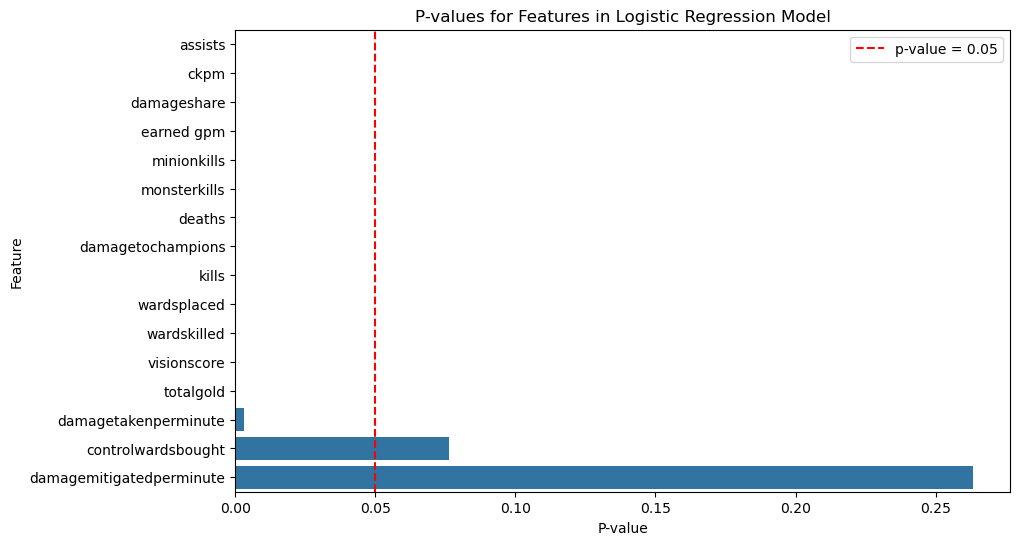

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

p_values = result.pvalues[1:]  # exclude constant
features = X_train.columns[1:]  # exclude constant

p_values_df = pd.DataFrame({
    'Feature': features,
    'P-value': p_values
}).sort_values(by='P-value', ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='P-value', y='Feature', data=p_values_df)

plt.axvline(x=0.05, color='r', linestyle='--', label='p-value = 0.05')
plt.title('P-values for Features in Logistic Regression Model')
plt.xlabel('P-value')
plt.ylabel('Feature')
plt.legend()
plt.show()

Conclusion: \
Since there exist features with p-values less than 0.05, we reject the null hypothesis. This indicates that individual statistics of professional League of Legends players significantly contribute to the outcome of a game. 

Extract all of the features that have a p-value less than 0.05 to use for the composite metric

In [25]:
important_features = p_values_df[p_values_df['P-value'] < 0.05]

X_adj = df[important_features['Feature'].values]

Train a Random Forest model on the important features, again using the result as a target to find out the feature weights

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# perform cross-validation
cv_scores = cross_val_score(rf_model, X_adj, y, cv=5, scoring='accuracy')  
print(f'Cross-validation scores: {cv_scores}')
print(f'Average accuracy: {cv_scores.mean()}')

# train the Random Forest model on the entire dataset to get feature importances
rf_model.fit(X_adj, y)

Cross-validation scores: [0.90602567 0.90718585 0.9106599  0.9142132  0.90717912]
Average accuracy: 0.9090527453007287


RandomForestClassifier(n_jobs=-1, random_state=42)

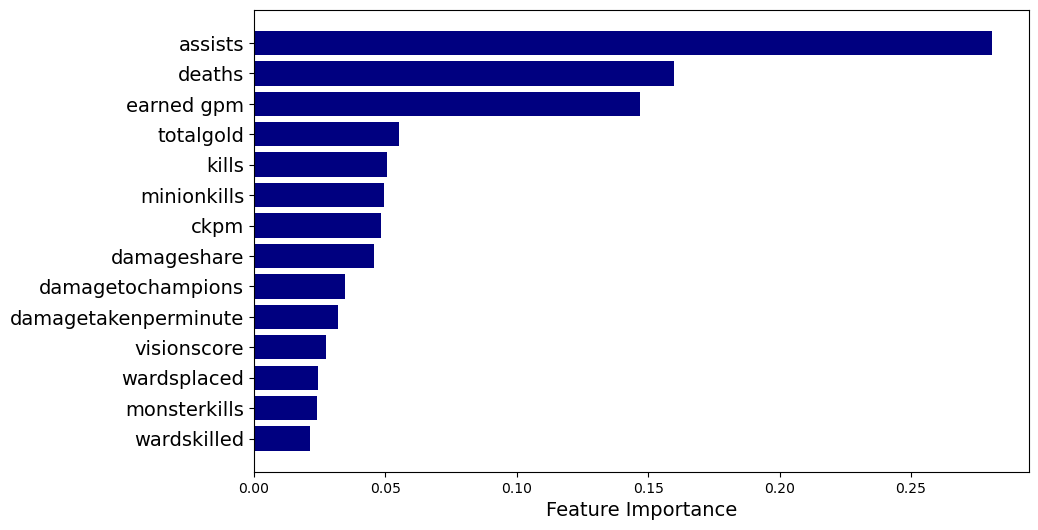

In [27]:
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_adj.columns,
    'Importance': feature_importances
})

# sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='#000080')
plt.xlabel('Feature Importance', fontsize=14)
plt.gca().invert_yaxis()

plt.yticks(fontsize=14) 
plt.show()

Find the correlation between each feature and the result

In [28]:
for feature in importance_df['Feature']:
    correlation = df[[feature, 'result']].corr(method='pearson')
    print(f"Correlation of {feature} with outcome: {correlation.iloc[0, 1]}")


Correlation of assists with outcome: 0.5571930198737738
Correlation of deaths with outcome: -0.5015048133368046
Correlation of earned gpm with outcome: 0.37962043649608035
Correlation of totalgold with outcome: 0.269633206331376
Correlation of kills with outcome: 0.3684680184870583
Correlation of minionkills with outcome: 0.010954710488547998
Correlation of ckpm with outcome: 0.004370908829536831
Correlation of damageshare with outcome: 8.93964728018843e-05
Correlation of damagetochampions with outcome: 0.15140217419638427
Correlation of damagetakenperminute with outcome: -0.0873248644946249
Correlation of visionscore with outcome: 0.07735297390952742
Correlation of wardsplaced with outcome: 0.009095645140868145
Correlation of monsterkills with outcome: 0.06020532536807729
Correlation of wardskilled with outcome: 0.07067377748574687


Looking at the correlation results, only deaths and damagetakenperminute negatively affect the result. It is too difficult to determine whether damageshare is helpful or harmful therefore I will not be utilizing it. 

Examine the important features along with their weights

In [29]:
print(importance_df)

                 Feature  Importance
0                assists    0.280808
6                 deaths    0.159860
3             earned gpm    0.146779
12             totalgold    0.055072
8                  kills    0.050700
4            minionkills    0.049312
1                   ckpm    0.048318
2            damageshare    0.045502
7      damagetochampions    0.034693
13  damagetakenperminute    0.032021
11           visionscore    0.027501
9            wardsplaced    0.024304
5           monsterkills    0.023850
10           wardskilled    0.021279


Re-calculate the weights to account for the relationships between the values (reverse normalize) to be able to use them for raw data entries

In [30]:
import pandas as pd

features = importance_df['Feature'].values
importances = importance_df['Importance'].values

columns_in_df = [feature for feature in features if feature in df.columns]

std_vals = df[columns_in_df].std()

adjusted_weights = {feature: importance_df.loc[importance_df['Feature'] == feature, 'Importance'].values[0] / std_vals[feature] 
                    for feature in columns_in_df}

In [31]:
adjusted_weights

{'assists': 0.06930291698775495,
 'deaths': 0.09147490853291804,
 'earned gpm': 0.0017483451018731155,
 'totalgold': 1.4994026866621013e-05,
 'kills': 0.02116208548962984,
 'minionkills': 0.00037834917933246033,
 'ckpm': 0.19532001895058795,
 'damageshare': 0.45358071056950583,
 'damagetochampions': 3.8991705104160675e-06,
 'damagetakenperminute': 0.00012888790677417677,
 'visionscore': 0.0008162120088924586,
 'wardsplaced': 0.0012322949371729322,
 'monsterkills': 0.00041552051372437826,
 'wardskilled': 0.0029094160761692503}

Account for the negative weight of deaths and damagetakenperminute

In [32]:
adjusted_weights['deaths'] = -abs(adjusted_weights['deaths'])
adjusted_weights['damagetakenperminute'] = -abs(adjusted_weights['damagetakenperminute'])

Calculate the sum of these weights for each row in the dataset, name it LPER

In [33]:
df['LPER'] = 0

for index, row in df.iterrows():
    LPER = 0
    for feature in columns_in_df:
        LPER += adjusted_weights[feature] * row[feature]
    df.at[index, 'LPER'] = LPER

/var/folders/0h/ch124vqs7dj_96gjw7qq3ksh0000gn/T/ipykernel_83228/2210354387.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5562696567570568' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'LPER'] = LPER


Find the average LPER per unique player

In [34]:
average_lper_df = df.groupby('playername')['LPER'].mean().reset_index()

average_lper_df.columns = ['playername', 'LPER']

Sort players by LPER

In [35]:
average_lper_df_sorted = average_lper_df.sort_values(by='LPER', ascending=False).reset_index(drop=True)

# reset indexes starting from 1
average_lper_df_sorted.index = average_lper_df_sorted.index + 1

df_lper = average_lper_df_sorted
df_lper

,playername,LPER
1,Peyz,1.683909
2,Rekkles,1.638864
3,Berserker,1.597246
4,Upset,1.593840
5,Aiming,1.588818
...,...,...
342,Zzus,0.765402
343,Pollu,0.753166
344,Secret,0.728566
345,Nova,0.714336


Clearly ADC's are too highly valued. Split the df into roles. First find the main position for each player.

In [36]:
player_roles = (
    df.groupby(['playername', 'position'])
    .size()
    .unstack(fill_value=0)  # Make positions into columns
    .reset_index()          # Ensure playername is a regular column
)

player_roles.columns.name = None
player_roles['position'] = player_roles.iloc[:, 1:].idxmax(axis=1)

player_roles

,playername,bot,jng,mid,sup,top,position
0,ADD,0,0,0,0,234,top
1,APA,0,0,92,0,0,mid
2,Abbedagge,0,0,255,0,0,mid
3,Ablazeolive,0,0,101,0,0,mid
4,Adam,0,0,0,0,197,top
...,...,...,...,...,...,...,...
341,kyeahoo,0,0,58,0,0,mid
342,nuc,0,0,199,0,0,mid
343,promisq,0,0,0,56,0,sup
344,ucal,0,0,232,0,0,mid


Add the position into the lper dataframe

In [37]:
df_lper = df_lper.merge(player_roles[['playername', 'position']], on='playername', how='left')

df_lper.head()

,playername,LPER,position
0,Peyz,1.683909,bot
1,Rekkles,1.638864,bot
2,Berserker,1.597246,bot
3,Upset,1.593840,bot
4,Aiming,1.588818,bot


Separate df's for each position for clarity

In [38]:
def split_df_by_position(df_lper):
    df_top = df_lper[df_lper['position'] == 'top']
    df_jng = df_lper[df_lper['position'] == 'jng']
    df_mid = df_lper[df_lper['position'] == 'mid']
    df_bot = df_lper[df_lper['position'] == 'bot']
    df_sup = df_lper[df_lper['position'] == 'sup']

    df_top = df_top.sort_values(by='LPER', ascending=False).reset_index(drop=True)
    df_top.index = df_top.index + 1

    df_jng = df_jng.sort_values(by='LPER', ascending=False).reset_index(drop=True)
    df_jng.index = df_jng.index + 1

    df_mid = df_mid.sort_values(by='LPER', ascending=False).reset_index(drop=True)
    df_mid.index = df_mid.index + 1

    df_bot = df_bot.sort_values(by='LPER', ascending=False).reset_index(drop=True)
    df_bot.index = df_bot.index + 1

    df_sup = df_sup.sort_values(by='LPER', ascending=False).reset_index(drop=True)
    df_sup.index = df_sup.index + 1
    
    return df_top, df_jng, df_mid, df_bot, df_sup

df_top, df_jng, df_mid, df_bot, df_sup = split_df_by_position(df_lper)

Analyze one of the dataframes for accuracy

In [39]:
df_top.head(30)

,playername,LPER,position
1,Nuguri,1.331674,top
2,Khan,1.327417,top
3,Fudge,1.307384,top
4,BrokenBlade,1.292232,top
5,Smeb,1.290666,top
6,Duke,1.276775,top
7,Alphari,1.275963,top
8,Photon,1.274620,top
9,Ssumday,1.259186,top
10,Armut,1.248439,top


Very easy to notice that European and American players are way overvalued compared to Korean players if you possess knowledge of the scene. Let's adjust this.

Use Riot Games' Official Region Power Rankings to adjust the LPER of each player based on their region's strength. This is not perfect, but should improve the ranking's usability significantly.

In [40]:
league_strengths = {
    'LEC': 1542,
    'LCS': 1486,
    'LCK': 1873
}

Recalculate the LPER for each player based on region

In [41]:
df['Adj_LPER'] = df.apply(lambda row: round(row['LPER'] * league_strengths[row['league']]), axis=1)

In [42]:
df_avg_lper = df.groupby('playername')['Adj_LPER'].mean().reset_index()
df_avg_lper['Adj_LPER'] = df_avg_lper['Adj_LPER'].round().astype(int)
df_avg_lper.rename(columns={'Adj_LPER': 'LPER'}, inplace=True)
df_avg_lper

,playername,LPER
0,ADD,2009
1,APA,2239
2,Abbedagge,2125
3,Ablazeolive,1691
4,Adam,1768
...,...,...
341,kyeahoo,2193
342,nuc,2038
343,promisq,1205
344,ucal,2359


In [43]:
df_lper_adjusted = df_avg_lper.merge(player_roles[['playername', 'position']], on='playername', how='left')
df_lper_adjusted

,playername,LPER,position
0,ADD,2009,top
1,APA,2239,mid
2,Abbedagge,2125,mid
3,Ablazeolive,1691,mid
4,Adam,1768,top
...,...,...,...
341,kyeahoo,2193,mid
342,nuc,2038,mid
343,promisq,1205,sup
344,ucal,2359,mid


Separate into roles again

In [44]:
df_top, df_jng, df_mid, df_bot, df_sup = split_df_by_position(df_lper_adjusted)

Reanalyze the top df

In [45]:
df_top.head(30)

,playername,LPER,position
1,Nuguri,2494,top
2,Khan,2486,top
3,Smeb,2417,top
4,Duke,2391,top
5,Doran,2333,top
6,Kiin,2331,top
7,Zeus,2315,top
8,Canna,2294,top
9,MaRin,2232,top
10,Sw0rd,2195,top


Despite being slightly too biased towards LCK players, this seems to be quite accurate, so let's proceed with these results

Find the z-score for each role to see deviation from mean for each player (how much better or worse a player is at their role than the average)

In [46]:
def calculate_z_scores(df):
    mean_lper = df['LPER'].mean()
    std_lper = df['LPER'].std()
    df['z_score'] = (df['LPER'] - mean_lper) / std_lper
    return df

df_top = calculate_z_scores(df_top)
df_jng = calculate_z_scores(df_jng)
df_mid = calculate_z_scores(df_mid)
df_bot = calculate_z_scores(df_bot)
df_sup = calculate_z_scores(df_sup)

In [47]:
df_top.head(30)

,playername,LPER,position,z_score
1,Nuguri,2494,top,2.298505
2,Khan,2486,top,2.265921
3,Smeb,2417,top,1.984890
4,Duke,2391,top,1.878994
5,Doran,2333,top,1.642764
6,Kiin,2331,top,1.634618
7,Zeus,2315,top,1.569452
8,Canna,2294,top,1.483920
9,MaRin,2232,top,1.231399
10,Sw0rd,2195,top,1.080701


The rankings of these players are fairly consistent with the general concensus of the community, let's try to merge everyone into one ranking

In [48]:
df_z_score = pd.concat([df_top, df_jng, df_mid, df_bot, df_sup], ignore_index=True)
df_z_score = df_z_score.sort_values(by='z_score', ascending=False).reset_index(drop=True)
df_z_score.index = df_z_score.index + 1

df_z_score

,playername,LPER,position,z_score
1,Chovy,2913,mid,2.785904
2,Peyz,3154,bot,2.767598
3,Keria,2065,sup,2.312110
4,Nuguri,2494,top,2.298505
5,Khan,2486,top,2.265921
...,...,...,...,...
342,LIDER,1730,mid,-1.807140
343,Ablazeolive,1691,mid,-1.958559
344,Sniper,1439,top,-1.998428
345,Kenvi,1213,jng,-2.261907


Chovy being by far the highest ranked player (regarded by most of the community to be the best), followed by other statistically exceptional players like Peyz Keria and Khan signals that the ranking is insightful and meaningful

For easier comprehension, let's adjust z-score by multiplying by making it non-negative, and increasing it by 1000 to be able to round it to an integer. Name this Z-LPER.

In [49]:
df_z_lper = df_z_score[['playername', 'position', 'z_score']]
df_z_lper['Z-LPER'] = (df_z_lper['z_score'] * 1000).round().astype(int)
df_z_lper['Z-LPER'] += abs(df_z_lper['Z-LPER'].min())
df_z_lper = df_z_lper.drop(columns='z_score')

df_z_lper

,playername,position,Z-LPER
1,Chovy,mid,5277
2,Peyz,bot,5259
3,Keria,sup,4803
4,Nuguri,top,4790
5,Khan,top,4757
...,...,...,...
342,LIDER,mid,684
343,Ablazeolive,mid,532
344,Sniper,top,493
345,Kenvi,jng,229


Inspect the top 30 players 

In [50]:
df_z_lper.head(30)

,playername,position,Z-LPER
1,Chovy,mid,5277
2,Peyz,bot,5259
3,Keria,sup,4803
4,Nuguri,top,4790
5,Khan,top,4757
6,Aiming,bot,4616
7,ShowMaker,mid,4597
8,Peanut,jng,4514
9,Canyon,jng,4486
10,Smeb,top,4476


Lets visualize and analyze the resulting ranking

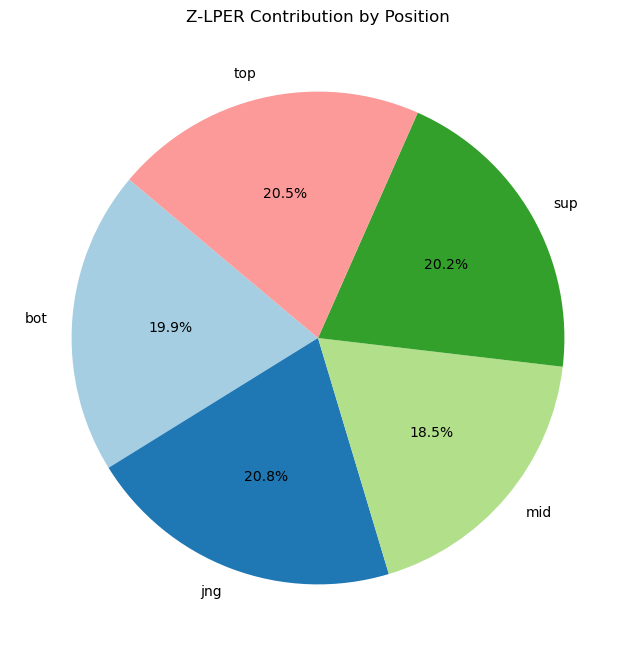

In [51]:
position_z_lper = df_z_lper.groupby("position")["Z-LPER"].sum()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    position_z_lper, 
    labels=position_z_lper.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Paired.colors
)
plt.title("Z-LPER Contribution by Position")
plt.show()


Each role is fairly even

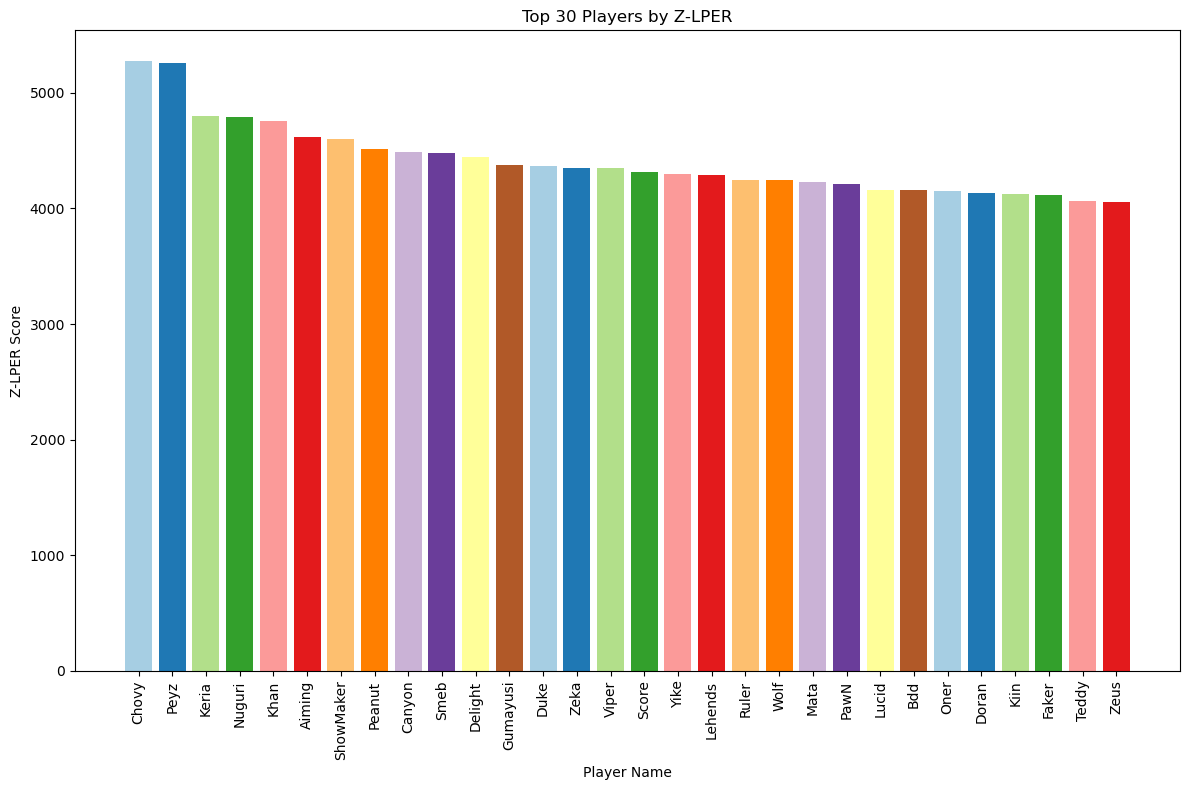

In [52]:
df_top30 = df_z_lper.head(30)

# Plotting a bar chart
plt.figure(figsize=(12, 8))
plt.bar(df_top30["playername"], df_top30["Z-LPER"], color=plt.cm.Paired.colors)
plt.xticks(rotation=90)
plt.xlabel("Player Name")
plt.ylabel("Z-LPER Score")
plt.title("Top 30 Players by Z-LPER")
plt.tight_layout()
plt.show()

Chovy and Peyz seem to be very exceptional statistically

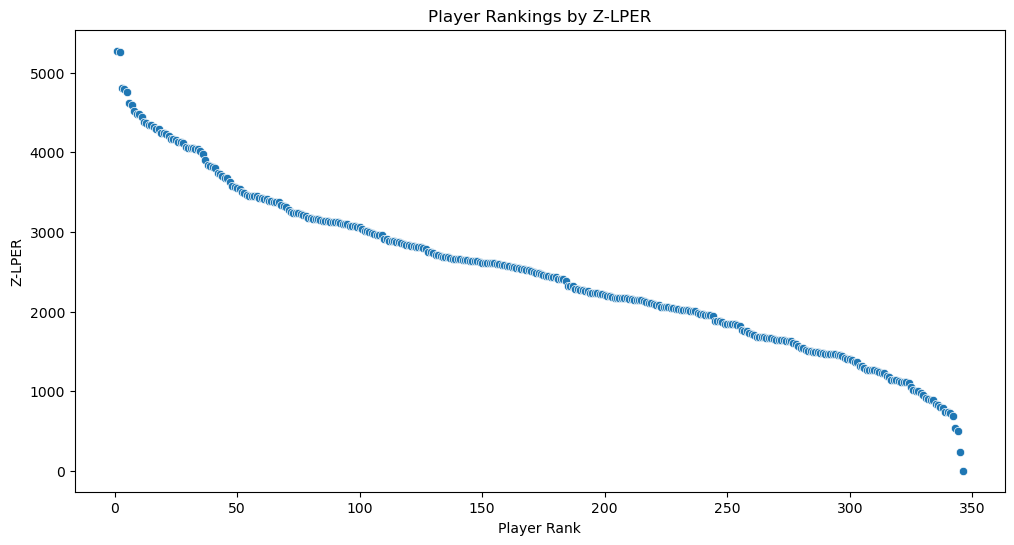

In [53]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='index', y='Z-LPER', data=df_z_lper.reset_index(), legend=None)
plt.xlabel('Player Rank')
plt.ylabel('Z-LPER')
plt.title('Player Rankings by Z-LPER')
plt.show()

Looks like the metric either starts to break down at the top and bottom or there are significant statistical outliers (Chovy and Peyz make sense to be so far ahead, the bottom is not as explainable)

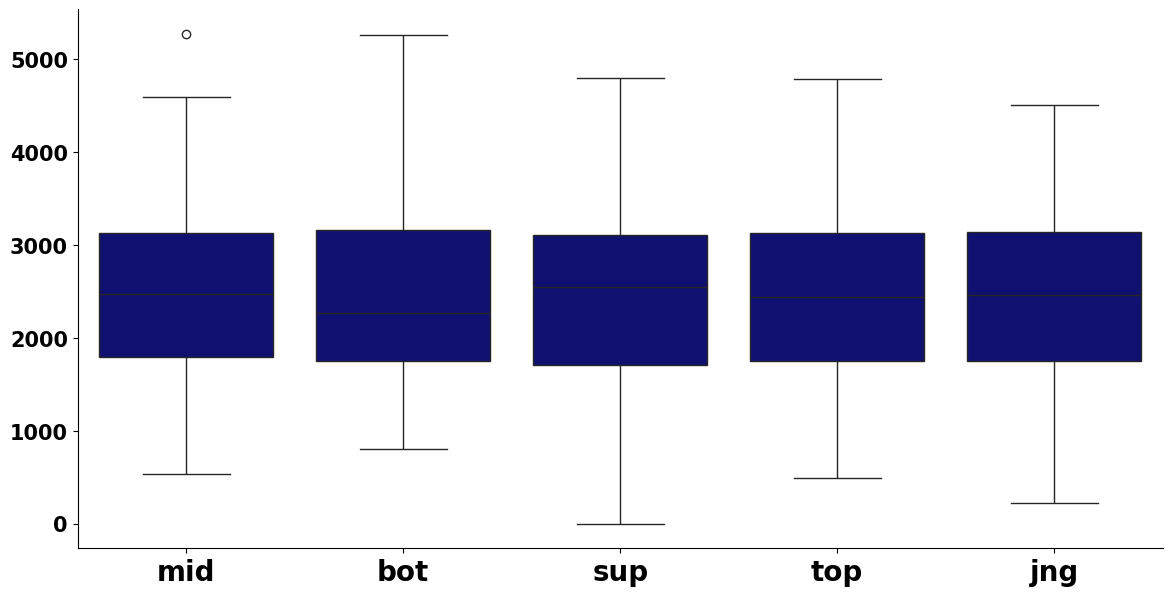

In [54]:
plt.figure(figsize=(14, 7))

# Draw the boxplot with navy blue bars and no lines
sns.boxplot(
    x='position', 
    y='Z-LPER', 
    data=df_z_lper, 
    color='#000080',   # Navy blue color for the boxes
)

# Hide the axis labels (x and y)
plt.xlabel('')
plt.ylabel('')

# Adjust tick parameters for better readability
plt.xticks(fontsize=20, weight='bold')
plt.yticks(fontsize=15, weight='bold')

# Remove grid lines
plt.grid(False)

# Remove spines for a cleaner look
sns.despine()

# Show the plot
plt.show()


Seems that bot is still biased towards, likely due to the role usually having the best stats. Also we can see just how much of an outlier Chovy is statistically.

### Conclusion:
 Despite them not being completely perfect and having outliers, these results are still quite insightful and can initiate a lot of discussion towards improvement in the application of data science towards the LoL Esports ecosystem.